In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


D:\Anaconda\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


#BATCH_SIZE = 32
#IMG_SIZE = (160, 160)
#train_dir='Database/Train/'
#validation_dir='Database/Valid/'
#train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            #shuffle=True,
                                                            #batch_size=BATCH_SIZE,
                                                            #image_size=IMG_SIZE)
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                # shuffle=True,
                                                                # batch_size=BATCH_SIZE,
                                                                 #image_size=IMG_SIZE)
#import tensorflow as tf
#AUTOTUNE = tf.data.AUTOTUNE

#train_dataset= train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_datagen = test_datagen.prefetch(buffer_size=AUTOTUNE)
 
batchsize = 10
train_generator=train_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_randomly/training_set/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_randomly/val_set/',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('RIM-ONE_DL_images/partitioned_randomly/test_set/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 339 images belonging to 2 classes.
Found 213 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


# Model Creation
VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.
Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [4]:
#DENSENET121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#DenseNet169
base_model2=keras.applications.DenseNet169(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)


#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




## setting all layers as non-trainable

In [5]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False

## Defining custom activation function
As per the paper, custom activation function Swish is used in place of Relu in the model.

In [6]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [7]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

## Defining Inception Block:
Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [8]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture
Global Average Pooling
Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [9]:
#DenseNet121
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [10]:
#DenseNet169
x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)

In [11]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [12]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [13]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [14]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [15]:

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_concat (Concatena  (None, 56, 56, 128)  0          ['conv2_block1_concat[0][0]',    
 te)                                                              'conv2_block2_2_conv[0][0]']    
                                                                                                  
 conv2_blo

 conv2_block6_concat (Concatena  (None, 56, 56, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 56, 56, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_relu (Activation)        (None, 56, 56, 256)  0           ['pool2_bn[0][0]']               
                                                                                                  
 pool2_conv (Conv2D)            (None, 56, 56, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 28, 28, 128)  0           ['pool2_conv[0][0]']             
          

                                                                                                  
 conv3_block4_concat (Concatena  (None, 28, 28, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, 28, 28, 256)  0          ['conv3_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block9_0_relu (Activatio  (None, 28, 28, 384)  0          ['conv3_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, 28, 28, 128)  49152       ['conv3_block9_0_relu[0][0]']    
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block9_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block1_0_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 128)  32768       ['conv4_block1_0_relu[0][0]']    
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_concat (Concatena  (None, 14, 14, 416)  0          ['conv4_block4_concat[0][0]',    
 te)                                                              'conv4_block5_2_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block9_concat (Concatena  (None, 14, 14, 544)  0          ['conv4_block8_concat[0][0]',    
 te)                                                              'conv4_block9_2_conv[0][0]']    
                                                                                                  
 conv4_block10_0_bn (BatchNorma  (None, 14, 14, 544)  2176       ['conv4_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv4_block10_0_relu (Activati  (None, 14, 14, 544)  0          ['conv4_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 128)  69632       ['conv4_block10_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 128)  86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block18_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_concat (Concaten  (None, 14, 14, 832)  0          ['conv4_block17_concat[0][0]',   
 ate)                                                             'conv4_block18_2_conv[0][0]']   
                                                                                                  
 conv4_block19_0_bn (BatchNorma  (None, 14, 14, 832)  3328       ['conv4_block18_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_0_relu (Activati  (None, 14, 14, 960)  0          ['conv4_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 128)  122880      ['conv4_block23_0_relu[0][0]']   
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block23_1_conv[0][0]']   
 lization)

 conv4_block27_1_conv (Conv2D)  (None, 14, 14, 128)  139264      ['conv4_block27_0_relu[0][0]']   
                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block31_1_relu[0][0]']   
                                                                                                  
 conv4_block31_concat (Concaten  (None, 14, 14, 1248  0          ['conv4_block30_concat[0][0]',   
 ate)                           )                                 'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, 14, 14, 1248  4992       ['conv4_block31_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block32_0_relu (Activati  (None, 14, 14, 1248  0          ['conv4_block32_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 7, 7, 736)   0           ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 7, 7, 736)   2944        ['conv5_block3_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_block8_0_bn (BatchNormal  (None, 7, 7, 864)   3456        ['conv5_block7_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 7, 7, 864)   0           ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 7, 7, 128)    110592      ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block12_1_conv (Conv2D)  (None, 7, 7, 128)    126976      ['conv5_block12_0_relu[0][0]']   
                                                                                                  
 conv5_block12_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block12_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 7, 7, 1152)  0           ['conv5_block15_concat[0][0]',   
 ate)                                                             'conv5_block16_2_conv[0][0]']   
                                                                                                  
 conv5_block17_0_bn (BatchNorma  (None, 7, 7, 1152)  4608        ['conv5_block16_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block21_0_bn (BatchNorma  (None, 7, 7, 1280)  5120        ['conv5_block20_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block21_0_relu (Activati  (None, 7, 7, 1280)  0           ['conv5_block21_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block21_1_conv (Conv2D)  (None, 7, 7, 128)    163840      ['conv5_block21_0_relu[0][0]']   
                                                                                                  
 conv5_block21_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block21_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block25_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block25_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block25_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block25_1_relu[0][0]']   
                                                                                                  
 conv5_block25_concat (Concaten  (None, 7, 7, 1440)  0           ['conv5_block24_concat[0][0]',   
 ate)     

 conv5_block29_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block29_1_relu[0][0]']   
                                                                                                  
 conv5_block29_concat (Concaten  (None, 7, 7, 1568)  0           ['conv5_block28_concat[0][0]',   
 ate)                                                             'conv5_block29_2_conv[0][0]']   
                                                                                                  
 conv5_block30_0_bn (BatchNorma  (None, 7, 7, 1568)  6272        ['conv5_block29_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block30_0_relu (Activati  (None, 7, 7, 1568)  0           ['conv5_block30_0_bn[0][0]']     
 on)                                                                                              
          

 batch_normalization_111 (Batch  (None, 7, 7, 512)   2048        ['lambda_17[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 512)   2048        ['lambda_20[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 7, 7, 512)   0           ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 512)    262656      ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_11

 batch_normalization_119 (Batch  (None, 7, 7, 512)   2048        ['lambda_25[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_122 (Batch  (None, 7, 7, 512)   2048        ['lambda_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_123 (Batch  (None, 7, 7, 512)   2048        ['lambda_29[0][0]']              
 Normalization)                                                                                   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Compiling the Model 

In [16]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['DenseNet169','DenseNet121','VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='DenseNet121':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='DenseNet169':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])

        
if __name__ == "__main__":
    comp()

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training the Models

### 1.DenseNet-121

In [17]:
#DenseNet121
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 27s 482ms/step - loss: 0.6275 - accuracy: 0.6873 - mse: 0.2173 - val_loss: 0.6936 - val_accuracy: 0.4930 - val_mse: 0.2502
Epoch 2/50
33/33 [==============================] - 9s 251ms/step - loss: 0.4947 - accuracy: 0.7375 - mse: 0.1649 - val_loss: 0.6931 - val_accuracy: 0.4930 - val_mse: 0.2500
Epoch 3/50
33/33 [==============================] - 8s 250ms/step - loss: 0.4434 - accuracy: 0.8024 - mse: 0.1419 - val_loss: 0.6942 - val_accuracy: 0.4930 - val_mse: 0.2505
Epoch 4/50
33/33 [==============================] - 8s 251ms/step - loss: 0.4193 - accuracy: 0.7935 - mse: 0.1345 - val_loss: 0.6942 - val_accuracy: 0.4930 - val_mse: 0.2505
Epoch 5/50
33/33 [==============================] - 9s 251ms/step - loss: 0.3890 - accuracy: 0.8378 - mse: 0.1205 - val_loss: 0.6914 - val_accuracy: 0.4930 - val_mse: 0.2491
Epoch 6/50
33/33 [==============================] - 9s 252ms/step - loss: 0.3631 - accuracy: 0.8614 - mse: 0.1108 - val_loss: 0.6

Epoch 48/50
33/33 [==============================] - 9s 252ms/step - loss: 0.0831 - accuracy: 0.9912 - mse: 0.0141 - val_loss: 0.1910 - val_accuracy: 0.9249 - val_mse: 0.0505
Epoch 49/50
33/33 [==============================] - 9s 253ms/step - loss: 0.1203 - accuracy: 0.9735 - mse: 0.0267 - val_loss: 0.1961 - val_accuracy: 0.9343 - val_mse: 0.0524
Epoch 50/50
33/33 [==============================] - 8s 251ms/step - loss: 0.0971 - accuracy: 0.9882 - mse: 0.0194 - val_loss: 0.1910 - val_accuracy: 0.9249 - val_mse: 0.0506
Execution Time :  444.86230659484863


In [18]:
model1.save('SavedModels/RIM ONE/Random/D121.h5')

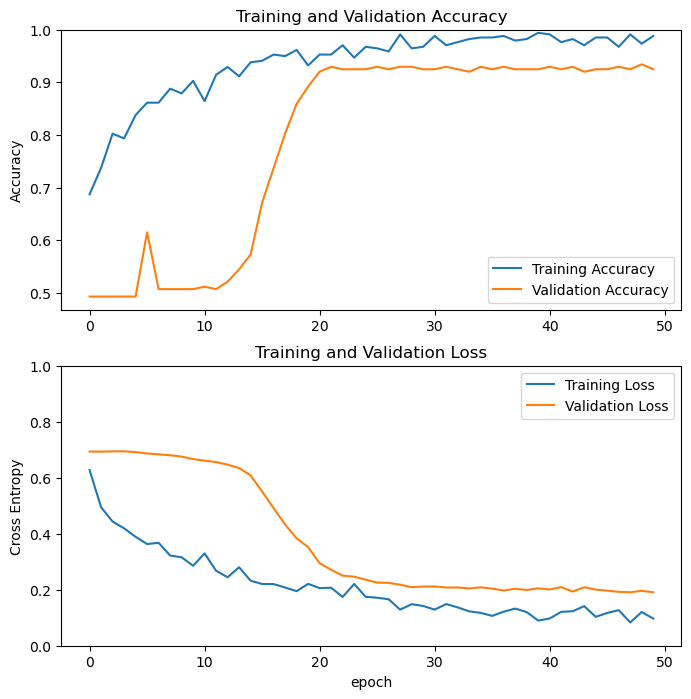

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

14/14 [==============================] - 5s 329ms/step - loss: 0.4450 - accuracy: 0.8014 - mse: 0.1327
['loss', 'accuracy', 'mse']
[0.44496259093284607, 0.801369845867157, 0.13270235061645508]
testing time : 4.9801411628723145


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 4s 128ms/step
Confusion Matrix
[[41 11]
 [18 76]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.69      0.79      0.74        52
      Normal       0.87      0.81      0.84        94

    accuracy                           0.80       146
   macro avg       0.78      0.80      0.79       146
weighted avg       0.81      0.80      0.80       146



In [22]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

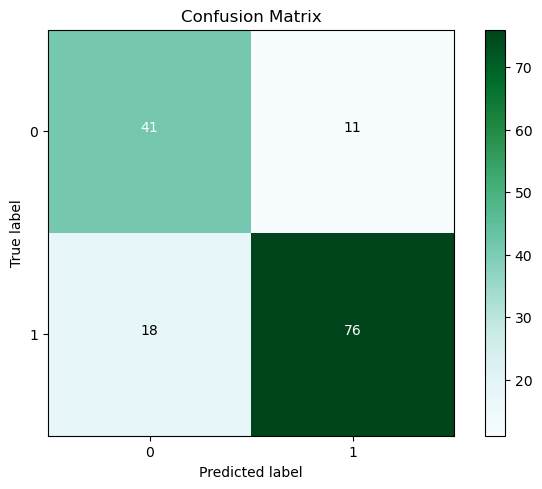

In [23]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### DenseNet-169

In [24]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 24s 442ms/step - loss: 0.6365 - accuracy: 0.6342 - mse: 0.2240 - val_loss: 0.7066 - val_accuracy: 0.4930 - val_mse: 0.2566
Epoch 2/50
33/33 [==============================] - 10s 288ms/step - loss: 0.5178 - accuracy: 0.7463 - mse: 0.1711 - val_loss: 0.7301 - val_accuracy: 0.4930 - val_mse: 0.2679
Epoch 3/50
33/33 [==============================] - 10s 289ms/step - loss: 0.4689 - accuracy: 0.7965 - mse: 0.1531 - val_loss: 0.7607 - val_accuracy: 0.4930 - val_mse: 0.2818
Epoch 4/50
33/33 [==============================] - 10s 288ms/step - loss: 0.4500 - accuracy: 0.7935 - mse: 0.1440 - val_loss: 0.7853 - val_accuracy: 0.4930 - val_mse: 0.2924
Epoch 5/50
33/33 [==============================] - 10s 287ms/step - loss: 0.4281 - accuracy: 0.8171 - mse: 0.1349 - val_loss: 0.7999 - val_accuracy: 0.4930 - val_mse: 0.2985
Epoch 6/50
33/33 [==============================] - 10s 289ms/step - loss: 0.4012 - accuracy: 0.8260 - mse: 0.1248 - val_loss

In [25]:

model2.save('SavedModels/RIM ONE/Random/D169.h5')

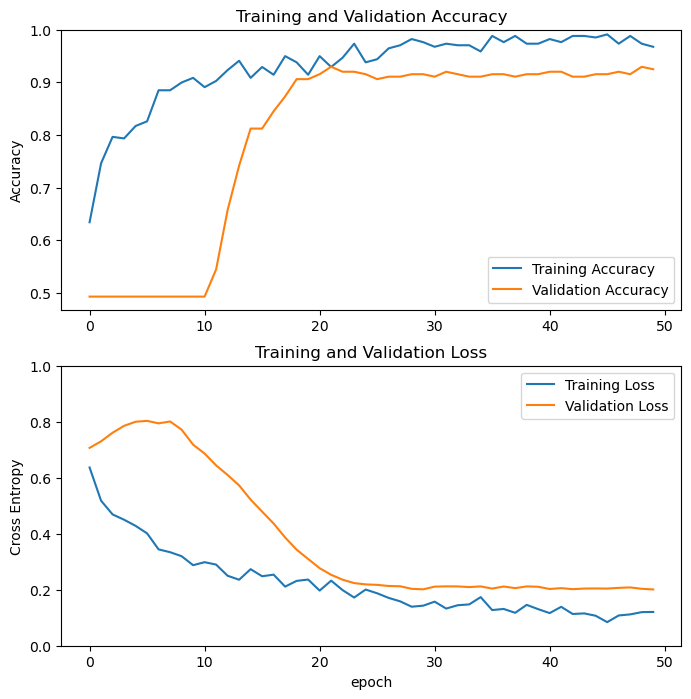

In [26]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

14/14 [==============================] - 4s 238ms/step - loss: 0.4937 - accuracy: 0.7877 - mse: 0.1586
['loss', 'accuracy', 'mse']
[0.493680864572525, 0.7876712083816528, 0.15862898528575897]
testing time : 3.708768129348755


In [28]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 4s 145ms/step
Confusion Matrix
[[42 10]
 [21 73]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.67      0.81      0.73        52
      Normal       0.88      0.78      0.82        94

    accuracy                           0.79       146
   macro avg       0.77      0.79      0.78       146
weighted avg       0.80      0.79      0.79       146



Text(0.5, 23.52222222222222, 'Predicted label')

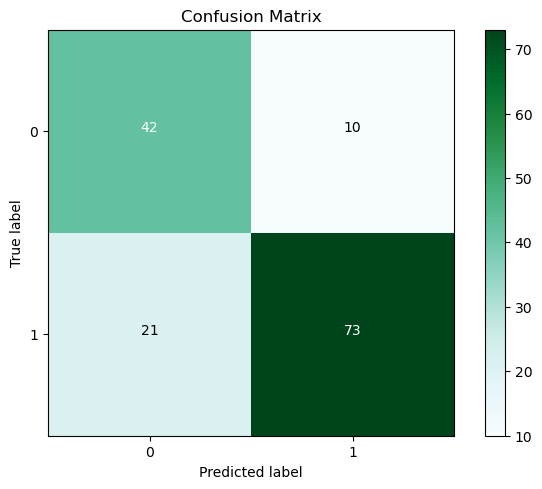

In [29]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3. VGG-19

In [17]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 41s 890ms/step - loss: 0.6918 - accuracy: 0.5516 - mse: 0.2489 - val_loss: 0.6933 - val_accuracy: 0.4930 - val_mse: 0.2501
Epoch 2/50
33/33 [==============================] - 21s 619ms/step - loss: 0.6055 - accuracy: 0.6755 - mse: 0.2081 - val_loss: 0.6955 - val_accuracy: 0.4930 - val_mse: 0.2512
Epoch 3/50
33/33 [==============================] - 21s 636ms/step - loss: 0.5466 - accuracy: 0.7316 - mse: 0.1817 - val_loss: 0.6960 - val_accuracy: 0.4930 - val_mse: 0.2514
Epoch 4/50
33/33 [==============================] - 21s 631ms/step - loss: 0.5198 - accuracy: 0.7640 - mse: 0.1702 - val_loss: 0.6953 - val_accuracy: 0.4930 - val_mse: 0.2511
Epoch 5/50
33/33 [==============================] - 21s 625ms/step - loss: 0.4869 - accuracy: 0.8112 - mse: 0.1557 - val_loss: 0.6883 - val_accuracy: 0.4930 - val_mse: 0.2477
Epoch 6/50
33/33 [==============================] - 16s 481ms/step - loss: 0.4712 - accuracy: 0.8171 - mse: 0.1498 - val_loss

In [18]:
model3.save('SavedModels/RIM ONE/Random/VGG19.h5')

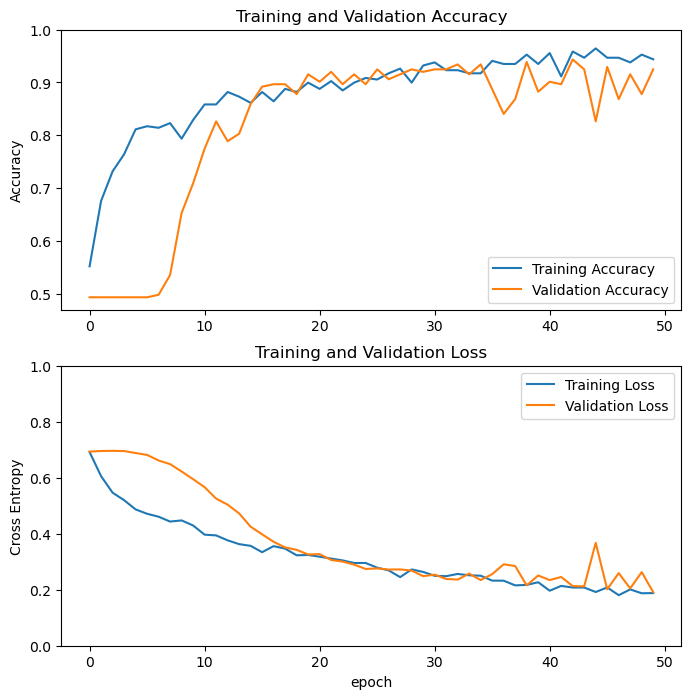

In [19]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

14/14 [==============================] - 5s 294ms/step - loss: 0.3408 - accuracy: 0.8151 - mse: 0.1127
['loss', 'accuracy', 'mse']
[0.34081897139549255, 0.8150684833526611, 0.1126672774553299]
testing time : 4.725378513336182


In [24]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 4s 298ms/step
Confusion Matrix
[[42 10]
 [17 77]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.71      0.81      0.76        52
      Normal       0.89      0.82      0.85        94

    accuracy                           0.82       146
   macro avg       0.80      0.81      0.80       146
weighted avg       0.82      0.82      0.82       146



Text(0.5, 23.52222222222222, 'Predicted label')

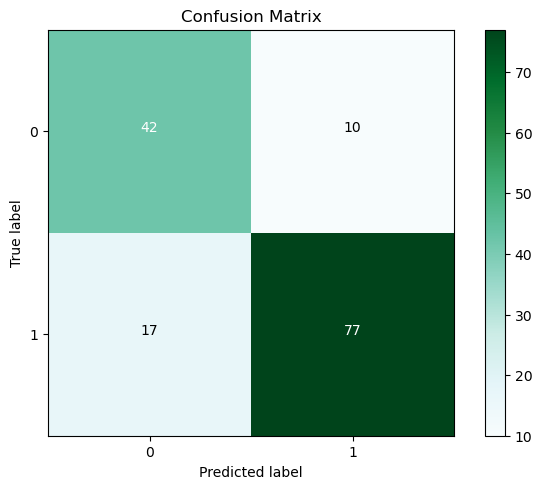

In [25]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4. MobileNet V2

In [26]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 14s 273ms/step - loss: 0.6316 - accuracy: 0.6401 - mse: 0.2214 - val_loss: 0.6381 - val_accuracy: 0.6573 - val_mse: 0.2232
Epoch 2/50
33/33 [==============================] - 6s 186ms/step - loss: 0.5003 - accuracy: 0.7699 - mse: 0.1651 - val_loss: 0.5959 - val_accuracy: 0.6901 - val_mse: 0.2038
Epoch 3/50
33/33 [==============================] - 6s 185ms/step - loss: 0.4140 - accuracy: 0.8525 - mse: 0.1293 - val_loss: 0.5446 - val_accuracy: 0.7324 - val_mse: 0.1807
Epoch 4/50
33/33 [==============================] - 6s 184ms/step - loss: 0.3856 - accuracy: 0.8643 - mse: 0.1184 - val_loss: 0.4959 - val_accuracy: 0.8028 - val_mse: 0.1595
Epoch 5/50
33/33 [==============================] - 6s 186ms/step - loss: 0.3591 - accuracy: 0.8643 - mse: 0.1069 - val_loss: 0.4476 - val_accuracy: 0.8638 - val_mse: 0.1392
Epoch 6/50
33/33 [==============================] - 6s 185ms/step - loss: 0.2966 - accuracy: 0.9292 - mse: 0.0813 - val_loss: 0.3

Epoch 48/50
33/33 [==============================] - 6s 185ms/step - loss: 0.0451 - accuracy: 0.9971 - mse: 0.0058 - val_loss: 0.2158 - val_accuracy: 0.9390 - val_mse: 0.0539
Epoch 49/50
33/33 [==============================] - 6s 185ms/step - loss: 0.0772 - accuracy: 0.9794 - mse: 0.0170 - val_loss: 0.2178 - val_accuracy: 0.9390 - val_mse: 0.0544
Epoch 50/50
33/33 [==============================] - 6s 185ms/step - loss: 0.0638 - accuracy: 0.9941 - mse: 0.0132 - val_loss: 0.2188 - val_accuracy: 0.9390 - val_mse: 0.0544
Execution Time :  324.11228251457214


In [27]:
model4.save('SavedModels/RIM ONE/Random/MobileNet.h5')

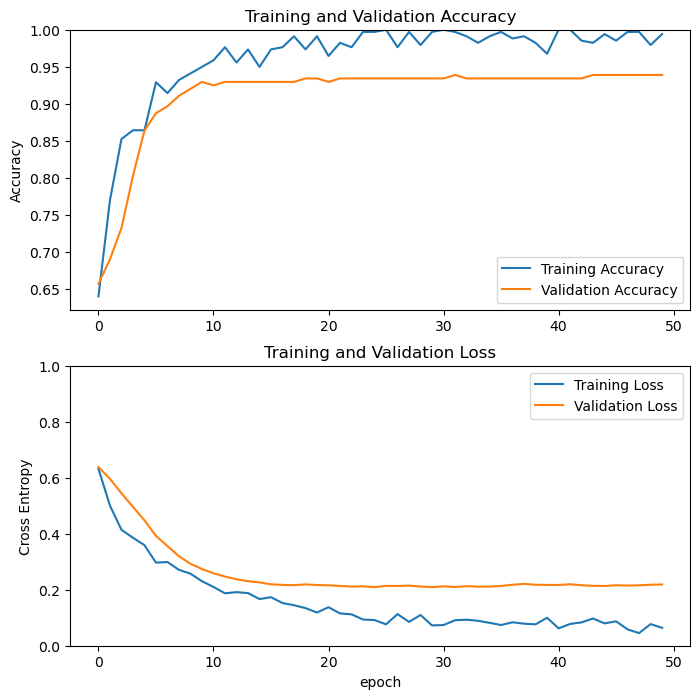

In [28]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

14/14 [==============================] - 2s 88ms/step - loss: 0.4999 - accuracy: 0.8219 - mse: 0.1394
['loss', 'accuracy', 'mse']
[0.4998611509799957, 0.8219178318977356, 0.13941840827465057]
testing time : 1.6813256740570068


In [33]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 1s 88ms/step
Confusion Matrix
[[41 11]
 [15 79]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.73      0.79      0.76        52
      Normal       0.88      0.84      0.86        94

    accuracy                           0.82       146
   macro avg       0.80      0.81      0.81       146
weighted avg       0.83      0.82      0.82       146



Text(0.5, 23.52222222222222, 'Predicted label')

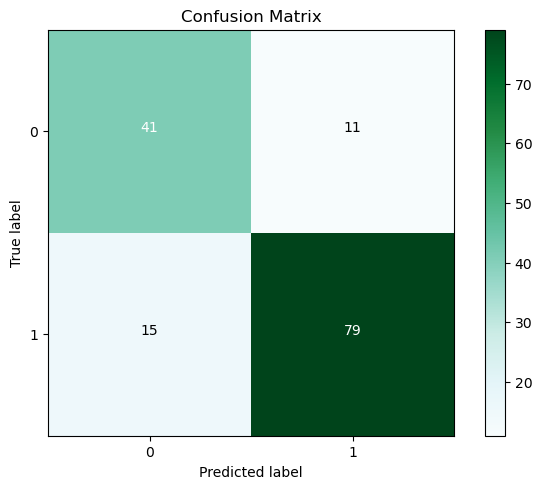

In [34]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ResNet50

In [35]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 18s 403ms/step - loss: 0.6864 - accuracy: 0.6195 - mse: 0.2466 - val_loss: 0.7716 - val_accuracy: 0.4930 - val_mse: 0.2866
Epoch 2/50
33/33 [==============================] - 11s 324ms/step - loss: 0.6783 - accuracy: 0.7198 - mse: 0.2426 - val_loss: 0.9110 - val_accuracy: 0.4930 - val_mse: 0.3393
Epoch 3/50
33/33 [==============================] - 11s 325ms/step - loss: 0.6704 - accuracy: 0.7463 - mse: 0.2387 - val_loss: 1.0741 - val_accuracy: 0.4930 - val_mse: 0.3854
Epoch 4/50
33/33 [==============================] - 11s 322ms/step - loss: 0.6627 - accuracy: 0.7670 - mse: 0.2348 - val_loss: 1.2469 - val_accuracy: 0.4930 - val_mse: 0.4204
Epoch 5/50
33/33 [==============================] - 11s 322ms/step - loss: 0.6559 - accuracy: 0.7581 - mse: 0.2315 - val_loss: 1.4160 - val_accuracy: 0.4930 - val_mse: 0.4450
Epoch 6/50
33/33 [==============================] - 11s 323ms/step - loss: 0.6486 - accuracy: 0.7670 - mse: 0.2278 - val_loss

In [36]:
model5.save('SavedModels/RIM ONE/Random/ResNet.h5')

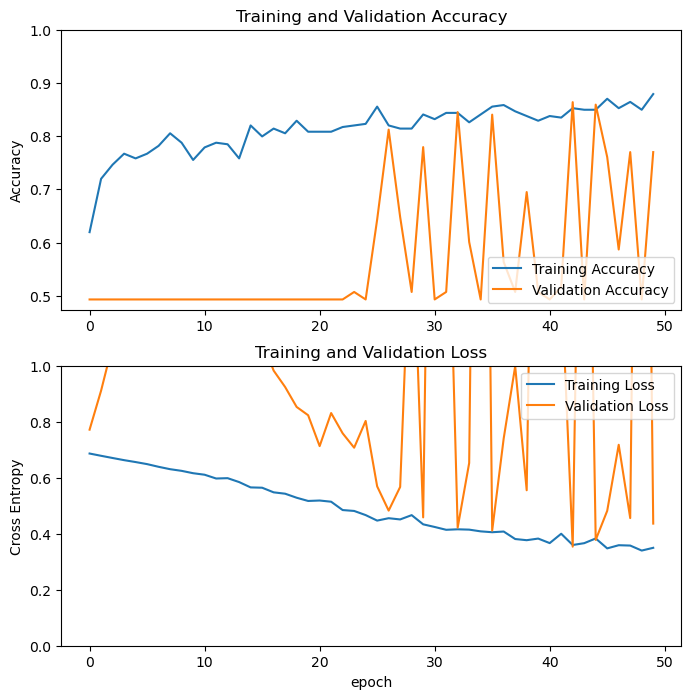

In [37]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

14/14 [==============================] - 3s 200ms/step - loss: 0.5684 - accuracy: 0.7123 - mse: 0.1930
['loss', 'accuracy', 'mse']
[0.5683662295341492, 0.7123287916183472, 0.1929859071969986]
testing time : 2.993497610092163


In [39]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 3s 141ms/step
Confusion Matrix
[[51  1]
 [41 53]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.55      0.98      0.71        52
      Normal       0.98      0.56      0.72        94

    accuracy                           0.71       146
   macro avg       0.77      0.77      0.71       146
weighted avg       0.83      0.71      0.71       146



Text(0.5, 23.52222222222222, 'Predicted label')

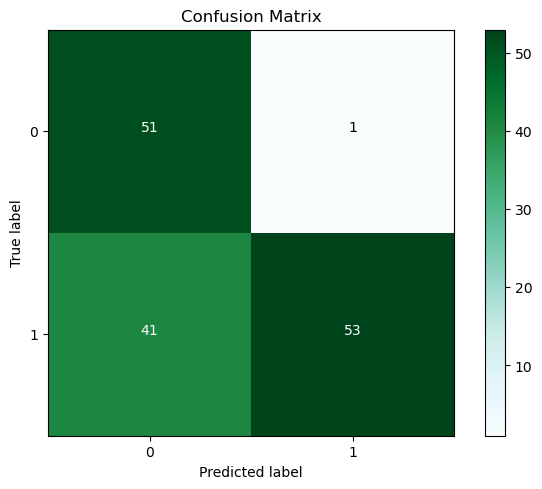

In [40]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6. Inception V3

In [41]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
33/33 [==============================] - 18s 367ms/step - loss: 0.7230 - accuracy: 0.5605 - mse: 0.2601 - val_loss: 0.7127 - val_accuracy: 0.4977 - val_mse: 0.2601
Epoch 2/50
33/33 [==============================] - 8s 231ms/step - loss: 0.4877 - accuracy: 0.7817 - mse: 0.1594 - val_loss: 0.6989 - val_accuracy: 0.4977 - val_mse: 0.2555
Epoch 3/50
33/33 [==============================] - 8s 230ms/step - loss: 0.3856 - accuracy: 0.8407 - mse: 0.1174 - val_loss: 0.6834 - val_accuracy: 0.5164 - val_mse: 0.2505
Epoch 4/50
33/33 [==============================] - 8s 231ms/step - loss: 0.3464 - accuracy: 0.8673 - mse: 0.1036 - val_loss: 0.6346 - val_accuracy: 0.5493 - val_mse: 0.2302
Epoch 5/50
33/33 [==============================] - 8s 230ms/step - loss: 0.2932 - accuracy: 0.9292 - mse: 0.0814 - val_loss: 0.5561 - val_accuracy: 0.6244 - val_mse: 0.1957
Epoch 6/50
33/33 [==============================] - 8s 230ms/step - loss: 0.2631 - accuracy: 0.9322 - mse: 0.0711 - val_loss: 0.4

Epoch 48/50
33/33 [==============================] - 8s 230ms/step - loss: 0.0525 - accuracy: 0.9971 - mse: 0.0085 - val_loss: 0.2451 - val_accuracy: 0.9014 - val_mse: 0.0674
Epoch 49/50
33/33 [==============================] - 8s 230ms/step - loss: 0.0552 - accuracy: 0.9912 - mse: 0.0108 - val_loss: 0.2469 - val_accuracy: 0.8967 - val_mse: 0.0680
Epoch 50/50
33/33 [==============================] - 8s 229ms/step - loss: 0.0576 - accuracy: 0.9853 - mse: 0.0115 - val_loss: 0.2492 - val_accuracy: 0.8920 - val_mse: 0.0685
Execution Time :  401.1760127544403


In [42]:
model6.save('SavedModels/RIM ONE/Random/Inception.h5')

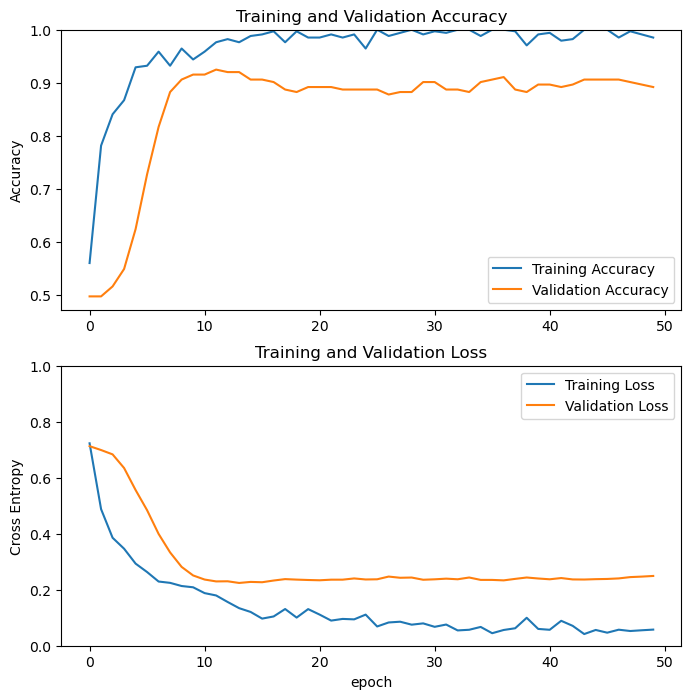

In [43]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

14/14 [==============================] - 3s 224ms/step - loss: 0.7514 - accuracy: 0.7329 - mse: 0.1954
['loss', 'accuracy', 'mse']
[0.7514118552207947, 0.732876718044281, 0.19540826976299286]
testing time : 3.447772979736328


In [45]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

15/15 [==============================] - 3s 114ms/step
Confusion Matrix
[[43  9]
 [30 64]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.59      0.83      0.69        52
      Normal       0.88      0.68      0.77        94

    accuracy                           0.73       146
   macro avg       0.73      0.75      0.73       146
weighted avg       0.77      0.73      0.74       146



Text(0.5, 23.52222222222222, 'Predicted label')

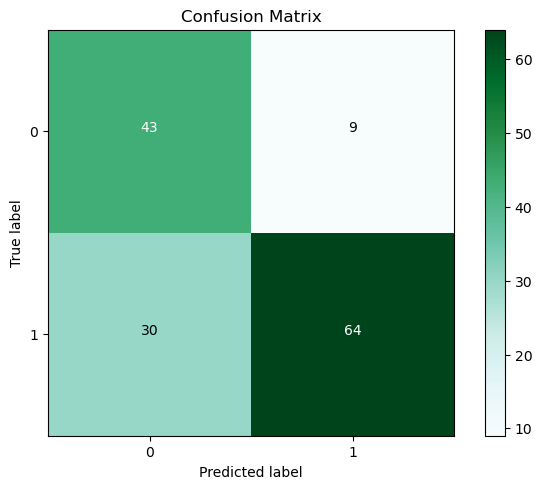

In [46]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')